# SPREP Data Testing

## Notes

We are close on this one.  Really just a few mods to the context and the sitemap and we are ready to index.  

* https://pacificdata.org/data/api/3/action/package_list
* https://pacificdata.org/data/api/3/action/package_show?id=SPC-DF_POP_COAST
* https://github.com/PacificCommunity/ckanext-spc-pdh/blob/master/ckanext/spc/schemas/dataset.json
* http://dev.d9fsm.sprep.wod.by/
* http://dev.d9fsm.sprep.wod.by/dataset/151/jsonld


In [7]:
import kglab as kg
from rdflib import Graph, plugin
from rdflib.serializer import Serializer
import pyshacl
import logging, sys
import json
from pyld import jsonld
import os, sys

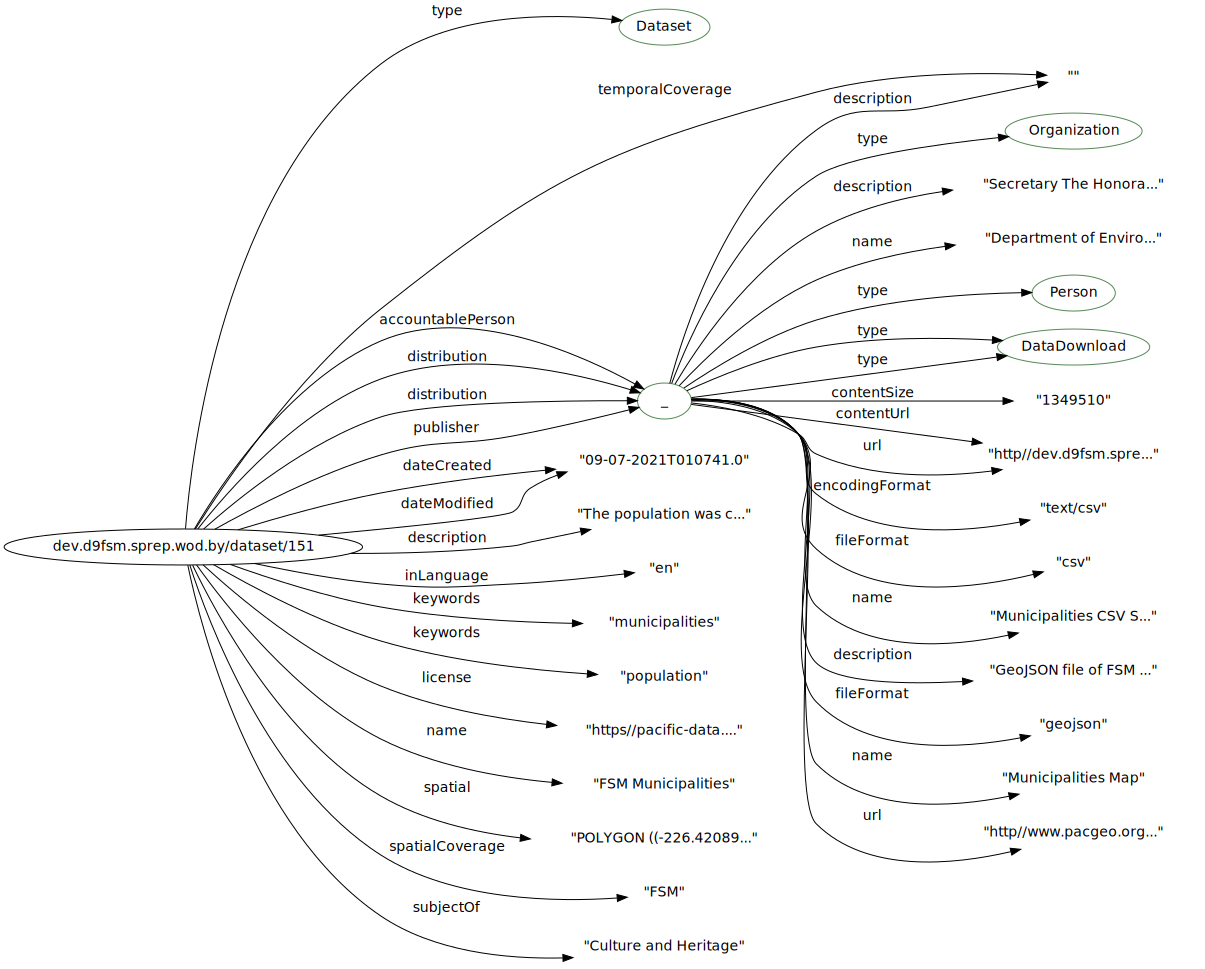

In [4]:


currentdir = os.path.dirname(os.path.abspath(''))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir)
from lib import jbutils

context = {"schema": "https://schema.org/", 
           "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
           "shacl": "http://www.w3.org/ns/shacl#" ,
           "oihval": "https://oceans.collaborium.io/voc/validation/1.0.1/shacl#" 
           }

# docurl = "http://dev.d9fsm.sprep.wod.by/dataset/151/jsonld"
# g = Graph().parse("http://dev.d9fsm.sprep.wod.by/dataset/151/jsonld", format='json-ld')
# sgjld = g.serialize(format='json-ld', context=context, indent=4)
# doc = json.loads("http://dev.d9fsm.sprep.wod.by/dataset/151/jsonld")

# load file
g = Graph().parse("./data/sprep1.json", format='json-ld')
sgjld = g.serialize(format='json-ld', context=context, indent=4)
doc = json.loads(sgjld)

# print(doc)

# compacted = jsonld.compact(docurl, context)
compacted = jsonld.compact(doc, context)


# jd = json.dumps(compacted, indent=4)
# print(jd)

jbutils.show_graph(compacted)

# Validation

Explore leveraging the SHACL patterns with this data

In [11]:
# set up the files we will use here
dg = './data/sprep1.json'
sg = '../validation/shapes/oih_dataset.ttl'

In [12]:
# pyshack sends output to log along with the vars.  This suppresses that
logging.disable(sys.maxsize)

In [13]:
import kglab

namespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

kg.load_jsonld(dg)

In [14]:
conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

In [15]:
print(report_text)


Validation Report
Conforms: False
Results (2):
Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: shacl:Violation
	Source Shape: oihval:urlResourceProperty
	Focus Node: <http://dev.d9fsm.sprep.wod.by/dataset/151>
	Result Path: schema:url
	Message: URL required for the location of the resource described by this metadata
Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: shacl:Violation
	Source Shape: oihval:identifierResourceProperty
	Focus Node: <http://dev.d9fsm.sprep.wod.by/dataset/151>
	Result Path: schema:identifier
	Message: Resource must have an identifier node



In [16]:
import pandas as pd
pd.set_option("max_rows", None)
        
sparql = """
SELECT ?path ?value ?constraint ?message ?id ?focus ?desc
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
    OPTIONAL {
        ?id shacl:description ?desc .
    }
  }
"""

df = report_graph.query_as_df(sparql)
df.head(10)

,path,constraint,message,id,focus
0,schema:url,shacl:MinCountConstraintComponent,URL required for the location of the resource ...,_:nb5c18011ca3c485d8079afb18763436bb2,<http://dev.d9fsm.sprep.wod.by/dataset/151>
1,schema:identifier,shacl:MinCountConstraintComponent,Resource must have an identifier node,_:nb5c18011ca3c485d8079afb18763436bb3,<http://dev.d9fsm.sprep.wod.by/dataset/151>
